# Multi Label Dataset Split with Stratification

In [1]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Pytorch: 1.7.1
Fastai: 2.2.7


In [4]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from torchvision.utils import save_image
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import PIL 
import os

In [5]:
pathToDataSet = "C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/"
path_anno = pathToDataSet + 'gt/'
path_img = pathToDataSet + 'done/'
get_y_fn = lambda x : path_anno + f'{x.stem}_GT.png'


label_fnames = get_image_files(path_anno)
fnames = get_image_files(path_img)
print(len(fnames), len(label_fnames))



508 508


## Generate DataSet Histogram

In [6]:
totalArray = []

for i in range(0,len(label_fnames)):
    img = Image.open(label_fnames[i])
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

print('Array Generated')


Array Generated


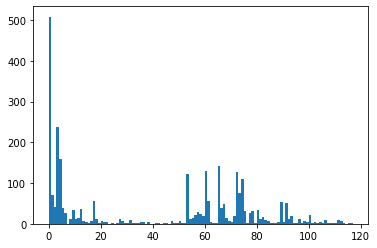

In [7]:
# histogram plot

hist = plt.hist(totalArray, bins=117, range=(0,117))
codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome
dicionario = {}


for code, contagem in zip(codes, hist[0]):
    dicionario[code] = int(contagem)

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=True)} #sort



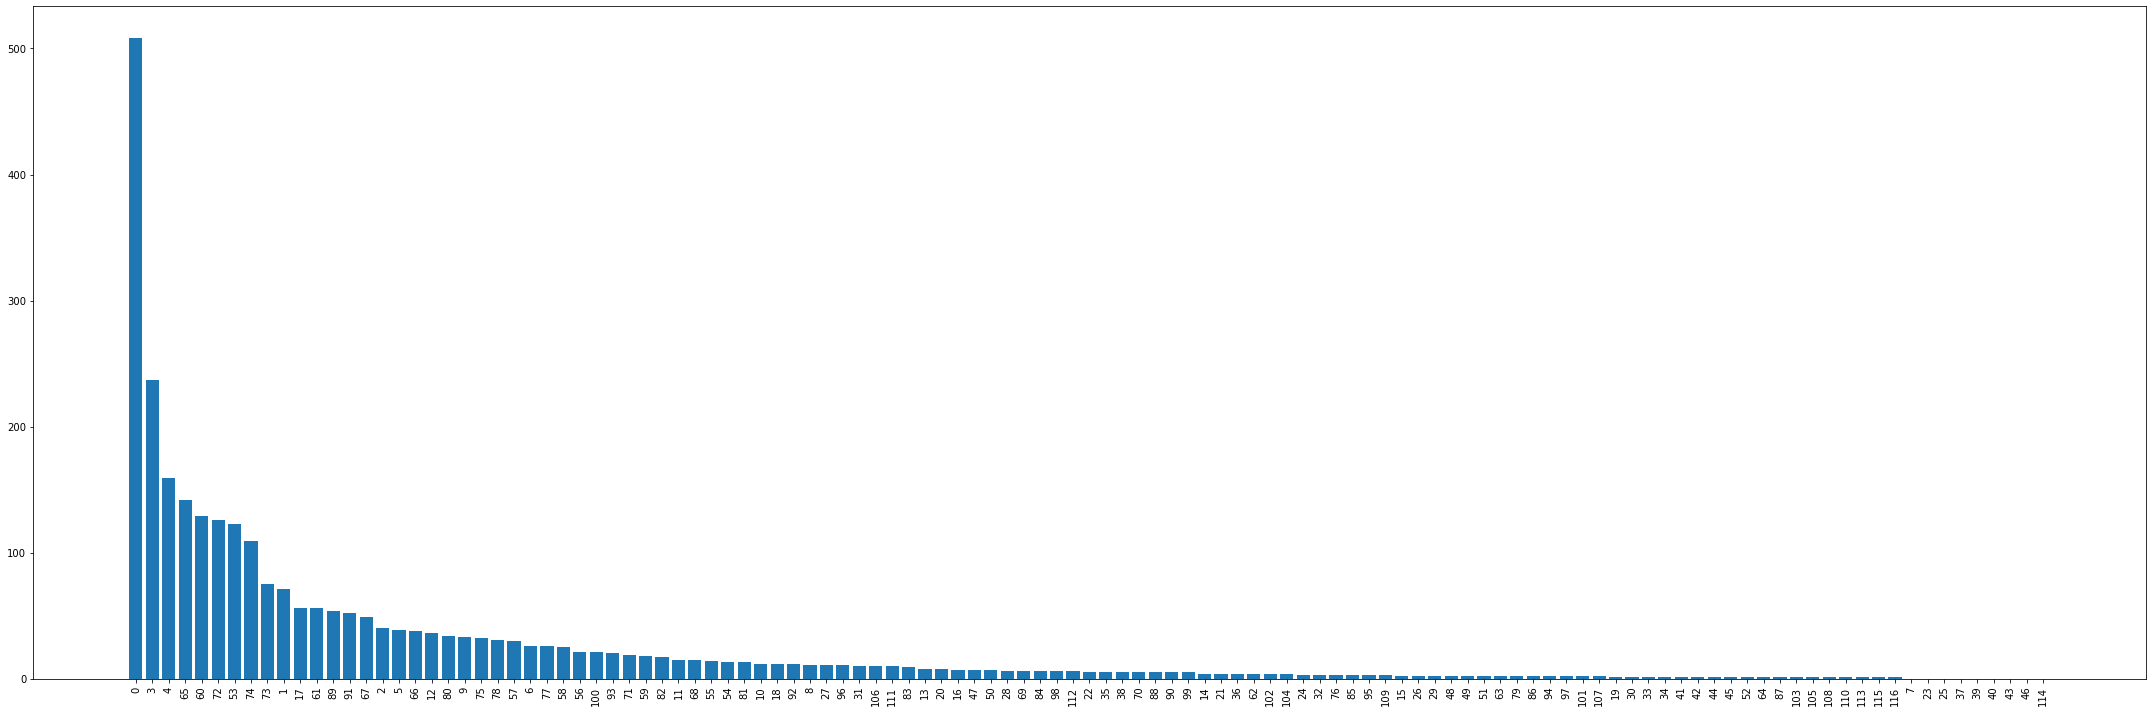

In [8]:
plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionario.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('originalClassesHist.png')
plt.show()

## Remove classes that appear less than a threshold

In [10]:
# get all ground truth images and label ids of each sample

allGTs = []
idsInGTs = []
for idx in range(0,len(label_fnames)):
    img = Image.open(label_fnames[idx])
    arr = np.asarray(img)
    idsInGTs.append(list(np.unique(arr,return_counts=False)))
    allGTs.append(arr)


In [11]:
def getImagesByClass(classId):
    imagesWithClass = []
    imagesIdx = []

    for i in range(0, len(label_fnames)):
        arr = allGTs[i]
        idsInGT = idsInGTs[i]
        if int(classId) in idsInGT:
            imagesWithClass.append(fnames[i])
            imagesIdx.append(i)
            

    return imagesWithClass, imagesIdx

In [12]:
# remove all images that has less than X samples

minClassAppearances = 3
idxsToRemove = []

for classId, classAppearances in dicionario.items():
    classImages, imagesIdx = getImagesByClass(classId)
    if classAppearances > 0 and len(imagesIdx) < minClassAppearances:
        idxsToRemove += imagesIdx
        print(classId,classImages,imagesIdx)

# remove repeated idxs
idxsToRemove = list(set(idxsToRemove))

fnamesManySamplesPerClass = [fnames[i] for i in range(0,len(fnames)) if i not in idxsToRemove]
label_fnamesManySamplesPerClass = [label_fnames[i] for i in range(0,len(label_fnames)) if i not in idxsToRemove]

len(fnamesManySamplesPerClass),len(label_fnamesManySamplesPerClass)

15 [Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/131.jpg'), Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/141.jpg')] [112, 123]
26 [Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/512.jpeg'), Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/513.jpeg')] [291, 292]
29 [Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/510.png'), Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/840.jpg')] [289, 457]
48 [Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Comidas Brasileiras TCC v1/dataset_v1/done/559.jpeg'), Path('C:/Users/bruno/Documents/diabetesLearning/foodDatabase/Dataset - Co

(469, 469)

## Split dataset

In [34]:
# get ids and images from all ground truths filtered in the last step!!!

idsInGTs = []
allGTs = []
for i in range(0,len(label_fnamesManySamplesPerClass)):
    img = Image.open(label_fnamesManySamplesPerClass[i])
    arr = np.asarray(img)
    idsInGTs.append(list(np.unique(arr,return_counts=False)))
    allGTs.append(arr)

In [35]:
def getImagesByClass(classId):
    imagesWithClass = []
    imagesIdx = []

    for i in range(0, len(label_fnamesManySamplesPerClass)):
        arr = allGTs[i]
        idsInGT = idsInGTs[i]
        if int(classId) in idsInGT:
            imagesWithClass.append(fnamesManySamplesPerClass[i])
            imagesIdx.append(i)
            

    return imagesWithClass, imagesIdx

In [36]:
# split multi label dataset with stratification: start from the classes with less appearances
# the testset size is not exactly as expected because it is difficult to split based on multi label ids. The results are close to the expected percentage

from sklearn.model_selection import train_test_split

trainIdxs = []
testIdxs = []
testsize = 0.2

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=False)} # reverse dict order (ascendent order)
for classId, classAppearances in dicionario.items():
    classImages, imagesIdx = getImagesByClass(classId)
    if len(imagesIdx) > 0:
        classTrain_idxs, classTest_idxs, _, _ = train_test_split(imagesIdx,imagesIdx, test_size=testsize, random_state=2)
        testIdxs += [idx for idx in classTest_idxs if idx not in testIdxs and idx not in trainIdxs]
        trainIdxs += [idx for idx in classTrain_idxs if idx not in testIdxs and idx not in trainIdxs]
        #print(classId, classAppearances, imagesIdx, classTrain_idxs, classTest_idxs)

len(trainIdxs), len(testIdxs)

(361, 108)

In [37]:

train_fnames = list(np.array(fnamesManySamplesPerClass)[trainIdxs])
train_label_fnames = list(np.array(label_fnamesManySamplesPerClass)[trainIdxs])

test_fnames = list(np.array(fnamesManySamplesPerClass)[testIdxs])
test_label_fnames = list(np.array(label_fnamesManySamplesPerClass)[testIdxs])

len(train_fnames), len(test_fnames)

(361, 108)

## Check stratification by plotting histograms for each dataset

### Testset

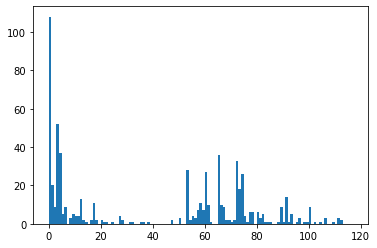

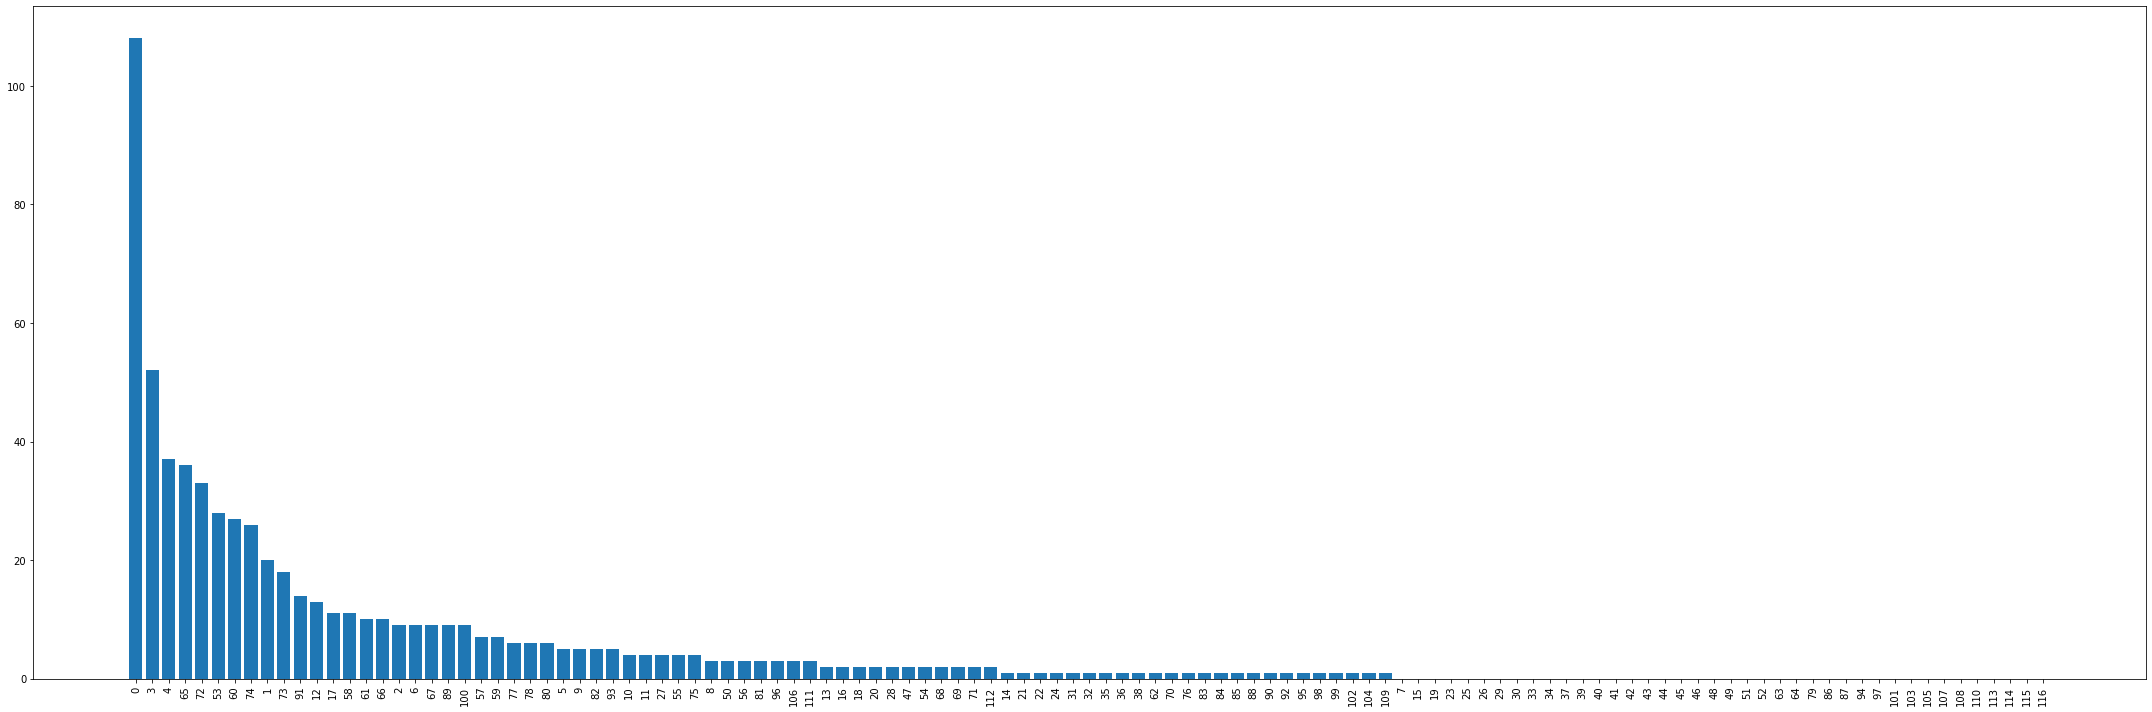

In [38]:
totalArray = []

for i in range(0,len(test_label_fnames)):
    img = Image.open(test_label_fnames[i])
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

hist = plt.hist(totalArray, bins=117, range=(0,117))
codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome
dicionarioTestset = {}


for code, contagem in zip(codes, hist[0]):
    dicionarioTestset[code] = int(contagem)

dicionarioTestset = {k: v for k, v in sorted(dicionarioTestset.items(), key=lambda item: item[1], reverse=True)} #sort

plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionarioTestset.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [39]:
# check how many classes have zero samples

testsetNullClasses = []
for classId, classAppearances in dicionarioTestset.items():
    if classAppearances == 0:
        testsetNullClasses.append(classId)
        #print(classId,classAppearances)

### Trainset

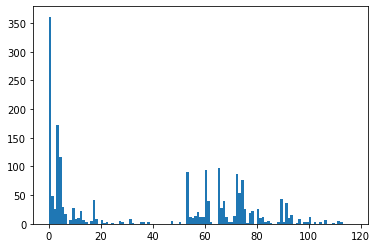

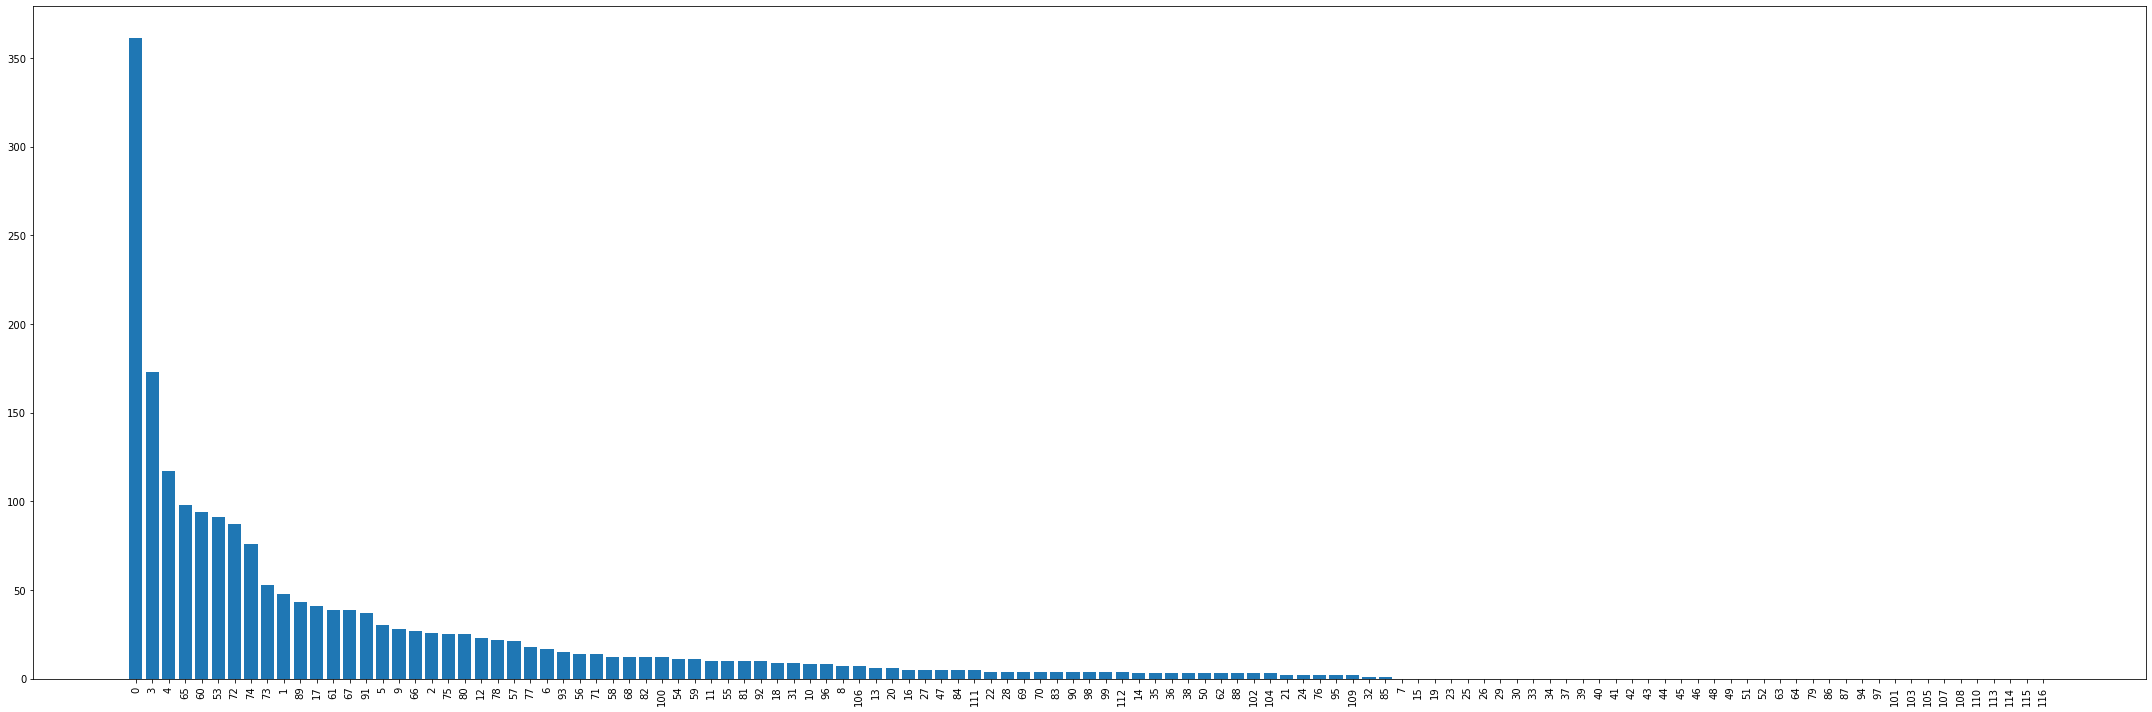

In [40]:
totalArray = []

for i in range(0,len(train_label_fnames)):
    img = Image.open(train_label_fnames[i])
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

hist = plt.hist(totalArray, bins=117, range=(0,117))
codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome
dicionarioTrainset = {}


for code, contagem in zip(codes, hist[0]):
    dicionarioTrainset[code] = int(contagem)

dicionarioTrainset = {k: v for k, v in sorted(dicionarioTrainset.items(), key=lambda item: item[1], reverse=True)} #sort

plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionarioTrainset.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [41]:
# check how many classes have zero samples

trainsetNullClasses = []
for classId, classAppearances in dicionarioTrainset.items():
    if classAppearances == 0:
        trainsetNullClasses.append(classId)
        #print(classId,classAppearances)

In [42]:
# this comparison should be true and their lengths equal

(trainsetNullClasses == testsetNullClasses), len(trainsetNullClasses), len(testsetNullClasses)


(True, 40, 40)

In [43]:
# compare test/train ratio for each class

for classId, classAppearances in dicionarioTrainset.items():
    if classAppearances > 0:
        testClassAppearances = dicionarioTestset[classId]
        print(classId, testClassAppearances/(testClassAppearances+classAppearances))
        if testClassAppearances/(testClassAppearances+classAppearances) <= 0.1:
            print("^^^^^^^^^Few samples in testset^^^^^^^^^")

0 0.2302771855010661
3 0.2311111111111111
4 0.24025974025974026
65 0.26865671641791045
60 0.2231404958677686
53 0.23529411764705882
72 0.275
74 0.2549019607843137
73 0.2535211267605634
1 0.29411764705882354
89 0.17307692307692307
17 0.21153846153846154
61 0.20408163265306123
67 0.1875
91 0.27450980392156865
5 0.14285714285714285
9 0.15151515151515152
66 0.2702702702702703
2 0.2571428571428571
75 0.13793103448275862
80 0.1935483870967742
12 0.3611111111111111
78 0.21428571428571427
57 0.25
77 0.25
6 0.34615384615384615
93 0.25
56 0.17647058823529413
71 0.125
58 0.4782608695652174
68 0.14285714285714285
82 0.29411764705882354
100 0.42857142857142855
54 0.15384615384615385
59 0.3888888888888889
11 0.2857142857142857
55 0.2857142857142857
81 0.23076923076923078
92 0.09090909090909091
^^^^^^^^^Few samples in testset^^^^^^^^^
18 0.18181818181818182
31 0.1
^^^^^^^^^Few samples in testset^^^^^^^^^
10 0.3333333333333333
96 0.2727272727272727
8 0.3
106 0.3
13 0.25
20 0.25
16 0.2857142857142857
2

## Export train and test sets with pickle

In [48]:
trainFilenames = [file.name for file in train_fnames]
testFilenames = [file.name for file in test_fnames] 
trainFilenames[0], testFilenames[0]

('459.jpeg', '511.jpeg')

In [49]:
# dump arrays into pickle file

with open('var/trainFilenames.pkl', 'wb') as f:
  pickle.dump(trainFilenames, f)
with open('var/testFilenames.pkl', 'wb') as f:
  pickle.dump(testFilenames, f)

In [52]:
# load arrays from pickle file

with open('var/trainFilenames.pkl', 'rb') as f:
  trainFiles = pickle.load(f)
with open('var/testFilenames.pkl', 'rb') as f:
  testFiles = pickle.load(f)